Searching for files in: /home/najo/NAS/VLA/Insertion_VLA/Make_dataset/async_inference_20251030_000056
Found CSV file: ./async_inference_20251030_000056/robot_state_20251030_000056.csv
Found JSON file: ./async_inference_20251030_000056/inference_results_20251030_000056.json
Note: Removed 6 duplicate timestamp entries from actual (CSV) data.
Calculating actual deltas over a 20-step (0.2s) window...
Loaded and calculated: 2659 actual 0.2s-window delta points.
Loaded and calculated: 270 generated 0.2s-total delta points.

--- Calculating RMSE for 0.2s Window DELTAS ---
Aligning actual deltas to 270 generated delta timestamps...
Comparing 235 aligned 0.2s delta windows.
  RMSE for EE-DELTA-X (0.2s): 4.2417
  RMSE for EE-DELTA-Y (0.2s): 1.0020
  RMSE for EE-DELTA-Z (0.2s): 3.6808
  RMSE for EE-DELTA-A (0.2s): 2.4671
  RMSE for EE-DELTA-B (0.2s): 9.4729
  RMSE for EE-DELTA-R (0.2s): 33.0969
  Average RMSE across all 0.2s DELTA axes: 8.9936
----------------------------------------------

Plott

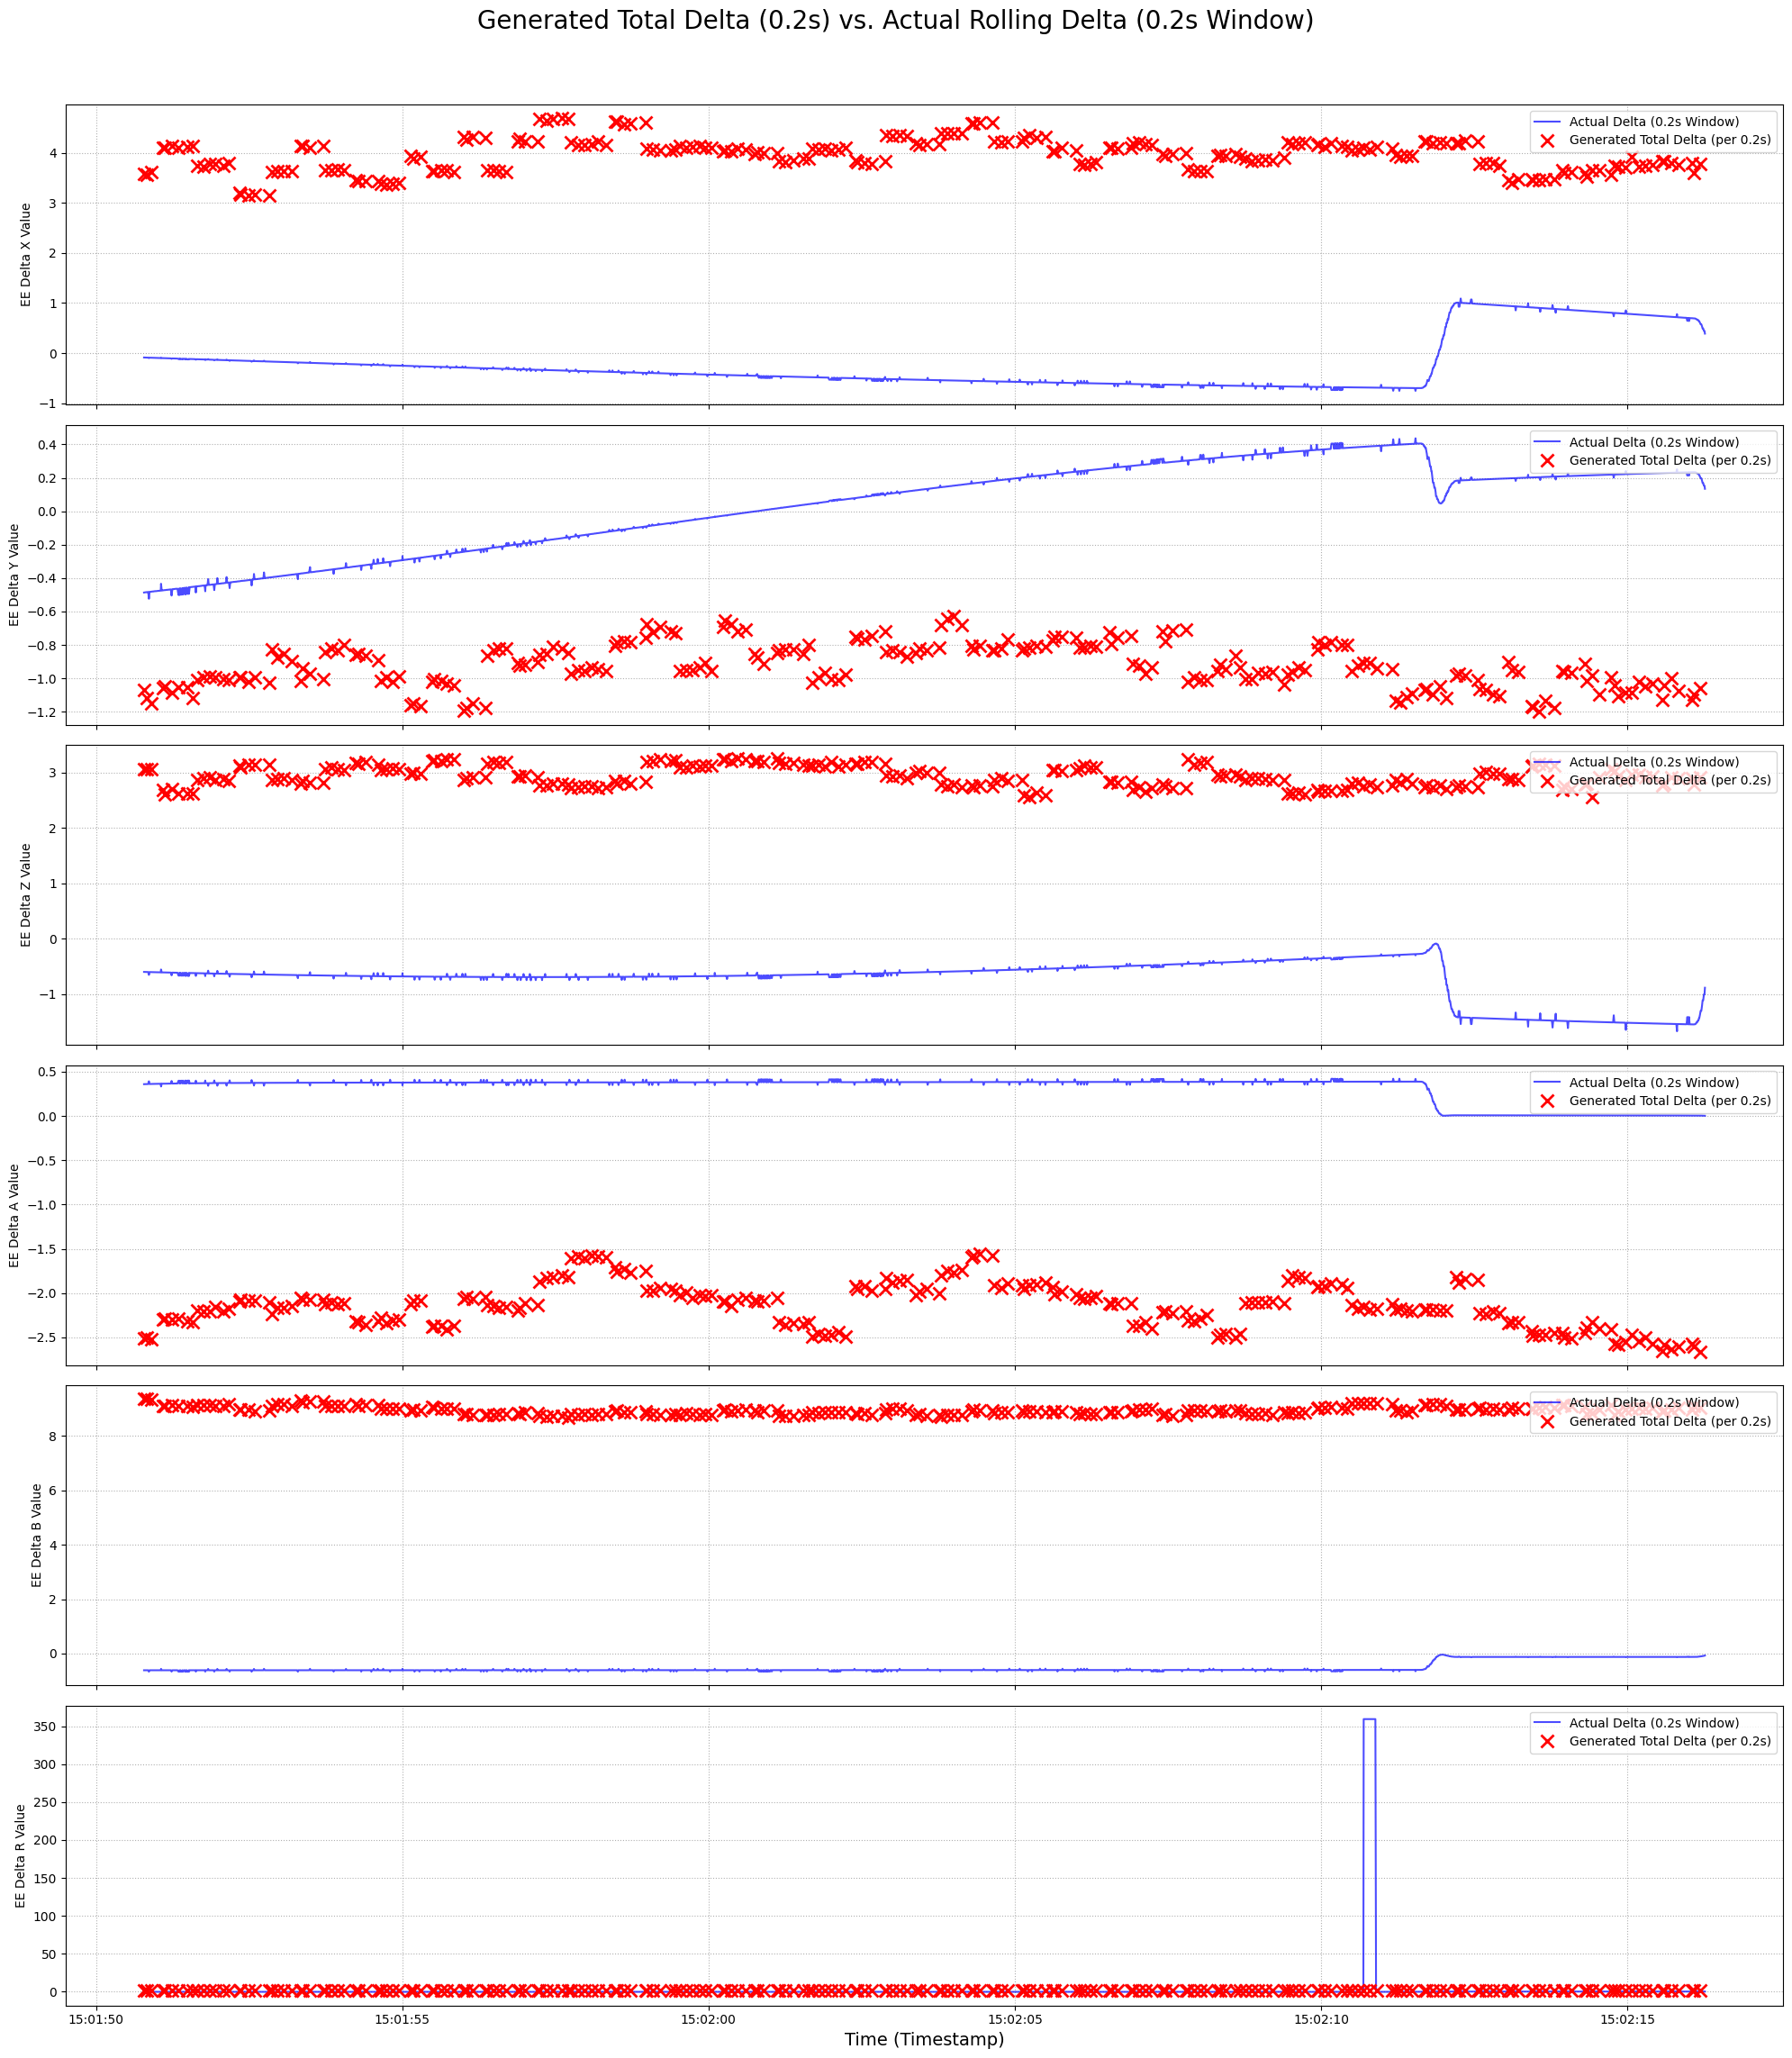

In [17]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import glob # 파일 검색을 위해 추가
import os   # 파일 경로 결합을 위해 추가

def load_generated_ee_deltas(json_path):
    """
    (이전과 동일)
    Loads JSON and calculates the TOTAL generated delta for each 0.2s chunk
    by SUMMING the 8 sequential 'actions'.
    """
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print("JSON decode error. Retrying as JSONL format (one object per line).")
        data = []
        with open(json_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
    
    all_gen_total_deltas = []
    
    for entry in data:
        try:
            end_time = pd.to_datetime(entry['timestamp'], unit='s')
            actions_deltas_list = entry['actions']
            if not actions_deltas_list:
                continue
            
            total_delta_vector = np.sum(
                [np.array(action[:6]) for action in actions_deltas_list], 
                axis=0
            )
            
            all_gen_total_deltas.append(
                {'timestamp': end_time, 'delta_vector': total_delta_vector}
            )
            
        except (KeyError, TypeError, IndexError) as e:
            print(f"Skipping a chunk due to data error: {e}")
                
    if not all_gen_total_deltas:
        print("No valid generated delta data was loaded.")
        return pd.DataFrame()
        
    df_generated = pd.DataFrame(all_gen_total_deltas)
    df_generated = df_generated.set_index('timestamp').sort_index()
    
    pose_labels = ['x', 'y', 'z', 'a', 'b', 'r']
    columns = [f'gen_delta_{label}' for label in pose_labels]
    df_generated[columns] = pd.DataFrame(
        df_generated['delta_vector'].tolist(), index=df_generated.index
    )
    df_generated = df_generated.drop(columns=['delta_vector'])
    
    df_generated = df_generated[~df_generated.index.duplicated(keep='first')]
    return df_generated

def load_actual_data(csv_path, window_size=20):
    """
    (이전과 동일)
    Loads the 'actual' robot data and calculates the DELTA over
    a 'window_size' (default 20 steps, e.g., 0.2s).
    """
    df = pd.read_csv(csv_path)
    
    rename_map = {
        'pose_x': 'act_pose_x', 'pose_y': 'act_pose_y', 'pose_z': 'act_pose_z',
        'pose_a': 'act_pose_a', 'pose_b': 'act_pose_b', 'pose_r': 'act_pose_r',
    }
    df = df.rename(columns=rename_map)
    pose_labels = ['x', 'y', 'z', 'a', 'b', 'r']
    
    if 'origin_timestamp' not in df.columns:
        if 'recv_timestamp' in df.columns:
            print("Warning: 'origin_timestamp' not found, falling back to 'recv_timestamp'.")
            df['timestamp'] = pd.to_datetime(df['recv_timestamp'], unit='s')
        else:
            raise KeyError("No suitable timestamp column found (expected 'origin_timestamp').")
    else:
        df['timestamp'] = pd.to_datetime(df['origin_timestamp'], unit='s')
        
    df = df.set_index('timestamp').sort_index()
    
    initial_count = len(df)
    df = df[~df.index.duplicated(keep='first')]
    final_count = len(df)
    if initial_count != final_count:
        print(f"Note: Removed {initial_count - final_count} duplicate timestamp entries from actual (CSV) data.")
    
    act_delta_cols = []
    print(f"Calculating actual deltas over a {window_size}-step (0.2s) window...")
    for label in pose_labels:
        pose_col = f'act_pose_{label}'
        delta_col = f'act_delta_{label}'
        if pose_col in df.columns:
            df[delta_col] = df[pose_col].diff(periods=window_size)
            act_delta_cols.append(delta_col)
        else:
            print(f"Warning: Column {pose_col} not found in CSV.")

    df = df.dropna(subset=act_delta_cols)
    
    return df[act_delta_cols]

def calculate_and_print_rmse(df_actual_deltas, df_generated_deltas):
    """
    (이전과 동일)
    Compares 'generated total delta' (sparse, 0.2s) with
    'actual 0.2s window delta' (dense, 100Hz).
    """
    print("\n--- Calculating RMSE for 0.2s Window DELTAS ---")
    pose_labels = ['x', 'y', 'z', 'a', 'b', 'r']
    
    df_gen_filtered = df_generated_deltas.copy()
    min_time = df_gen_filtered.index.min()
    max_time = df_gen_filtered.index.max()
    
    if df_gen_filtered.empty or (min_time >= max_time):
        print("No generated deltas found to compare.")
        return

    print(f"Aligning actual deltas to {len(df_gen_filtered)} generated delta timestamps...")
    df_act_resampled = df_actual_deltas.reindex(
        df_gen_filtered.index, 
        method='nearest', 
        tolerance=pd.Timedelta('0.05s')
    )
    
    comparison_df = df_gen_filtered.join(df_act_resampled)
    comparison_df = comparison_df.dropna()
    
    if comparison_df.empty:
        print("No data points aligned for comparison after resampling.")
        return

    print(f"Comparing {len(comparison_df)} aligned 0.2s delta windows.")

    total_rmse = 0.0
    valid_axes_count = 0
    for label in pose_labels:
        act_col = f'act_delta_{label}'
        gen_col = f'gen_delta_{label}'
        
        if act_col in comparison_df.columns and gen_col in comparison_df.columns:
            mse = mean_squared_error(
                comparison_df[act_col], 
                comparison_df[gen_col]
            )
            rmse = np.sqrt(mse)
            total_rmse += rmse
            valid_axes_count += 1
            print(f"  RMSE for EE-DELTA-{label.upper()} (0.2s): {rmse:.4f}")
        else:
            print(f"  Skipping EE-DELTA-{label.upper()}: Column not found.")
            
    if valid_axes_count > 0:
        print(f"  Average RMSE across all 0.2s DELTA axes: {total_rmse / valid_axes_count:.4f}")
    print("----------------------------------------------\n")

def plot_delta_comparison(df_actual_deltas, df_generated_deltas):
    """
    (이전과 동일)
    Plots 'generated total delta' (sparse, 0.2s) vs.
    'actual 0.2s window delta' (dense, 100Hz).
    """
    min_time = max(df_actual_deltas.index.min(), df_generated_deltas.index.min())
    max_time = min(df_actual_deltas.index.max(), df_generated_deltas.index.max())
    
    if min_time >= max_time:
        print("Error: No overlapping time range found for plotting deltas.")
        return

    df_actual_filtered = df_actual_deltas.loc[min_time:max_time]
    df_generated_filtered = df_generated_deltas.loc[min_time:max_time]

    if df_generated_filtered.empty or df_actual_filtered.empty:
        print("Error: No data found in the overlapping time range for plotting deltas.")
        return

    print(f"Plotting 0.2s DELTA comparison from {min_time} to {max_time}")

    fig, axes = plt.subplots(6, 1, figsize=(20, 24), sharex=True)
    fig.suptitle('Generated Total Delta (0.2s) vs. Actual Rolling Delta (0.2s Window)', fontsize=20)
    pose_labels = ['x', 'y', 'z', 'a', 'b', 'r']

    for i, label in enumerate(pose_labels):
        ax = axes[i]
        act_col = f'act_delta_{label}'
        gen_col = f'gen_delta_{label}'
        
        if act_col in df_actual_filtered.columns:
            ax.plot(df_actual_filtered.index, df_actual_filtered[act_col], 
                    label=f'Actual Delta (0.2s Window)', color='blue', alpha=0.7, linewidth=1.5)
        
        if gen_col in df_generated_filtered.columns:
            ax.plot(df_generated_filtered.index, df_generated_filtered[gen_col], 
                    label=f'Generated Total Delta (per 0.2s)', 
                    color='red', linestyle='None', marker='x', markersize=10, markeredgewidth=2)
        
        ax.set_ylabel(f'EE Delta {label.upper()} Value')
        ax.legend(loc='upper right')
        ax.grid(True, linestyle=':')
    
    axes[-1].set_xlabel('Time (Timestamp)', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# ---!!! 메인 실행 블록 수정됨 !!!---
if __name__ == "__main__":
    
    # ---!!! 여기에 폴더 경로만 지정하세요 !!!---
    TARGET_DIRECTORY = './async_inference_20251030_000056' # 예: '/home/najo/data/experiment_1'
    # ----------------------------------------
    
    CSV_WINDOW_SIZE = 20 # 0.2s / 0.01s = 20 steps

    # ! 'sklearn' 설치 필요: pip install scikit-learn
    # ! 'numpy' 설치 필요: pip install numpy
    
    try:
        # 1. 지정된 폴더에서 .csv 와 .json 파일 검색
        print(f"Searching for files in: {os.path.abspath(TARGET_DIRECTORY)}")
        
        # os.path.join을 사용하여 OS 호환 경로 생성
        csv_files = glob.glob(os.path.join(TARGET_DIRECTORY, '*.csv'))
        json_files = glob.glob(os.path.join(TARGET_DIRECTORY, '*.json'))
        
        # 2. 파일 개수 확인
        if len(csv_files) == 0:
            print(f"Error: No .csv file found in {TARGET_DIRECTORY}")
            exit()
        if len(json_files) == 0:
            print(f"Error: No .json file found in {TARGET_DIRECTORY}")
            exit()
        
        if len(csv_files) > 1:
            print(f"Error: Multiple .csv files found. Please ensure only one is present.")
            print(csv_files)
            exit()
        if len(json_files) > 1:
            print(f"Error: Multiple .json files found. Please ensure only one is present.")
            print(json_files)
            exit()
            
        # 3. 파일 경로 설정
        CSV_FILE_PATH = csv_files[0]
        JSON_FILE_PATH = json_files[0]
        
        print(f"Found CSV file: {CSV_FILE_PATH}")
        print(f"Found JSON file: {JSON_FILE_PATH}")

        # 4. 데이터 로드 및 비교
        df_actual_deltas = load_actual_data(CSV_FILE_PATH, window_size=CSV_WINDOW_SIZE)
        print(f"Loaded and calculated: {len(df_actual_deltas)} actual 0.2s-window delta points.")
        
        df_generated_deltas = load_generated_ee_deltas(JSON_FILE_PATH)
        print(f"Loaded and calculated: {len(df_generated_deltas)} generated 0.2s-total delta points.")

        if not df_generated_deltas.empty and not df_actual_deltas.empty:
            calculate_and_print_rmse(df_actual_deltas=df_actual_deltas, 
                                     df_generated_deltas=df_generated_deltas)
            
            plot_delta_comparison(df_actual_deltas=df_actual_deltas, 
                                  df_generated_deltas=df_generated_deltas)
        else:
            print("One or both delta data sources are empty. Cannot proceed.")

    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")